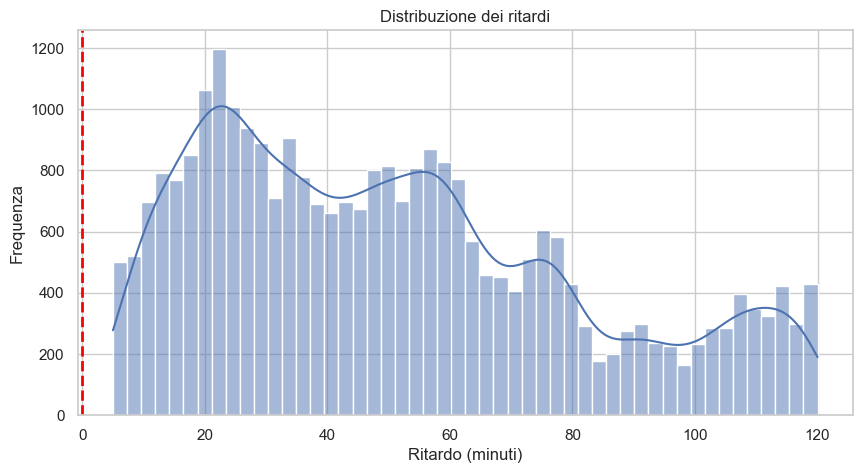


The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



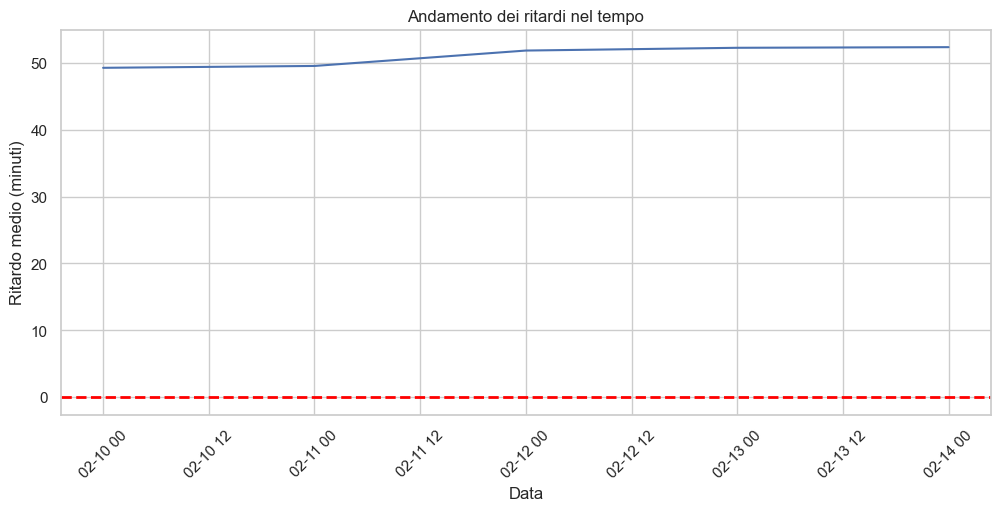

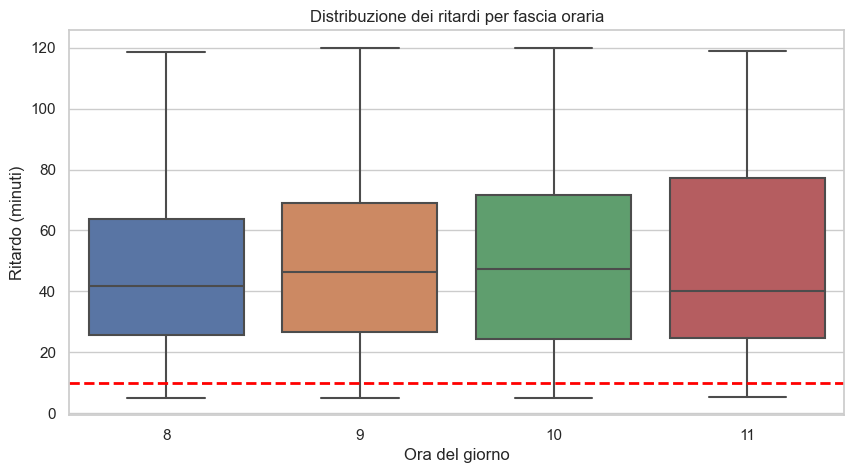

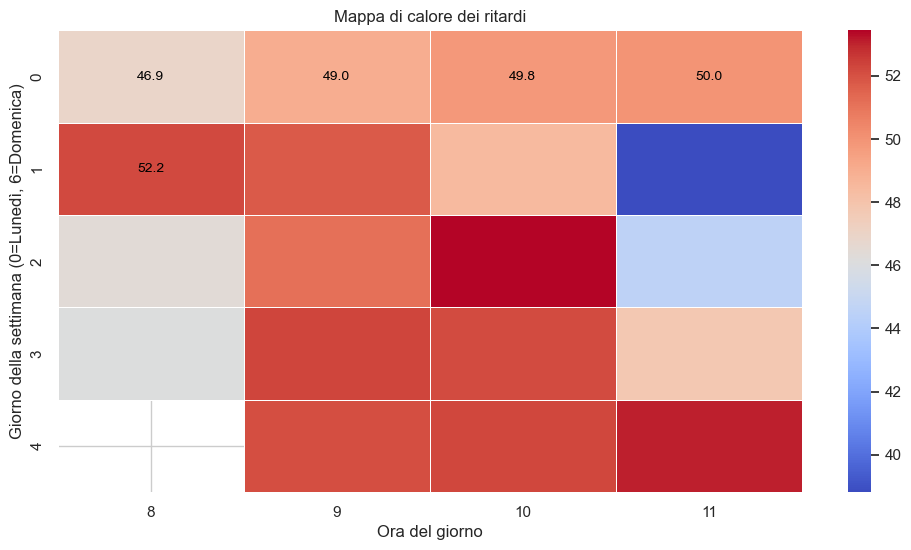

hour                8          9          10         11
day_of_week                                            
0            46.912217  49.035676  49.785320  49.988889
1            52.228767  51.773385  48.442484  38.812698
2            46.392917  51.115703  53.440667  44.535135
3            46.091304  52.338589  52.182901  47.729412
4                  NaN  52.092492  52.261440  53.060606


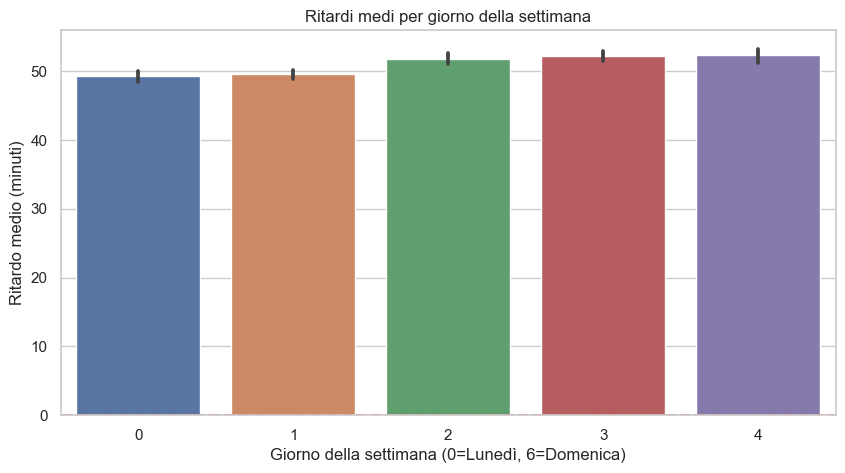

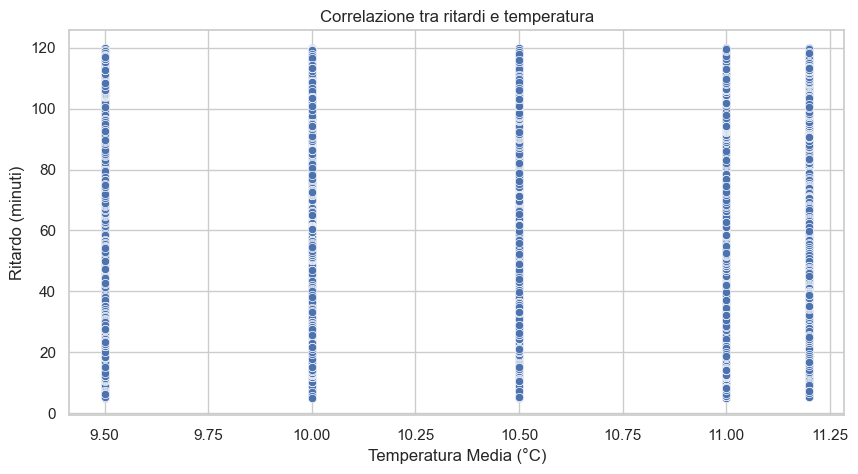

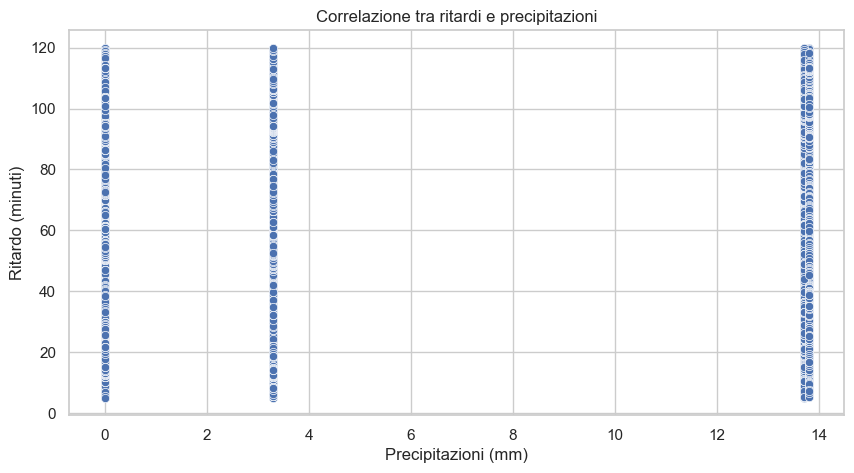

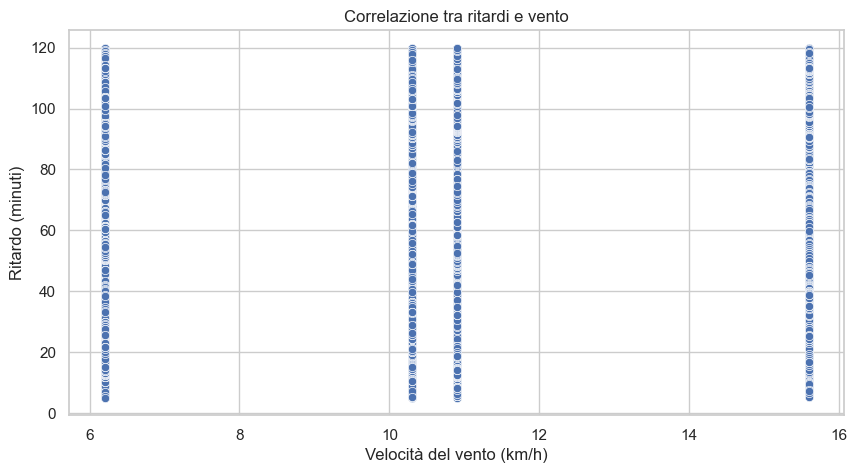

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Daily, Point
from datetime import datetime

file_ritardi = "C:/Users/C.Marino/Desktop/dataset/ritardi_consistenti.txt"
df = pd.read_csv(file_ritardi, sep=",")


df['delay'] = pd.to_timedelta(df['delay'], errors='coerce')

#Crea una colonna per i ritardi in minuti
df['delay_minutes'] = df['delay'].dt.total_seconds() / 60

#Rimuove i valori NaN 
df = df.dropna(subset=['delay_minutes'])
df = df[df['delay_minutes'].between(-60, 120)]  # Filtra ritardi tra -60 e 120 minuti

#Converte le date e le ore in formato corretto
df['arrival_date'] = pd.to_datetime(df['arrival_date'], errors='coerce')
df = df.dropna(subset=['arrival_date'])  # Evita problemi nel merge
df['hour'] = pd.to_datetime(df['arrival_time_x'], errors='coerce').dt.hour
df['hour'] = pd.to_numeric(df['hour'], errors='coerce').fillna(-1).astype(int)  # Evita errori se ci sono NaN
df['day_of_week'] = df['arrival_date'].dt.dayofweek  # 0 = Lunedì, ..., 6 = Domenica

#Recupero dati meteo Roma 
start = datetime(2025, 2, 10)
end = datetime(2025, 2, 14)
rome = Point(41.9028, 12.4964)
weather = Daily(rome, start, end)
weather = weather.fetch()

weather = weather.reset_index()
weather['time'] = pd.to_datetime(weather['time'])
weather = weather[['time', 'tavg', 'prcp', 'wspd']]  
weather.rename(columns={'time': 'arrival_date'}, inplace=True)

#Merge tra dati ritardi e dati meteo
if not weather.empty:
    df = df.merge(weather, on='arrival_date', how='left')
else:
    print("Attenzione: Nessun dato meteo trovato, il dataset verrà usato senza meteo.")


sns.set_theme(style="whitegrid")

#Istogramma della distribuzione dei ritardi
plt.figure(figsize=(10, 5))
sns.histplot(df['delay_minutes'], bins=50, kde=True)
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Ritardo (minuti)")
plt.ylabel("Frequenza")
plt.title("Distribuzione dei ritardi")
plt.show()

#Andamento dei ritardi nel tempo
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x="arrival_date", y="delay_minutes", ci=None)
plt.axhline(y=0, color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Data")
plt.ylabel("Ritardo medio (minuti)")
plt.title("Andamento dei ritardi nel tempo")
plt.xticks(rotation=45)
plt.show()

#Distribuzione dei ritardi per fasce orarie
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['hour'], y=df['delay_minutes'])
plt.axhline(y=10, color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Ora del giorno")
plt.ylabel("Ritardo (minuti)")
plt.title("Distribuzione dei ritardi per fascia oraria")
plt.show()

#Heatmap dei ritardi per giorno della settimana e ora

heatmap_data = df.pivot_table(values='delay_minutes', index='day_of_week', columns='hour', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    cmap="coolwarm",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    annot_kws={"size": 10, "color": "black"}
   
)
plt.xlabel("Ora del giorno")
plt.ylabel("Giorno della settimana (0=Lunedì, 6=Domenica)")
plt.title("Mappa di calore dei ritardi")
plt.show()

print(heatmap_data)



#Ritardi medi per giorno della settimana
plt.figure(figsize=(10, 5))
sns.barplot(x=df['day_of_week'], y=df['delay_minutes'], estimator=np.mean)
plt.axhline(y=0, color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Giorno della settimana (0=Lunedì, 6=Domenica)")
plt.ylabel("Ritardo medio (minuti)")
plt.title("Ritardi medi per giorno della settimana")
plt.show()


#Correlazione tra ritardi e meteo
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='tavg', y='delay_minutes')
plt.xlabel("Temperatura Media (°C)")
plt.ylabel("Ritardo (minuti)")
plt.title("Correlazione tra ritardi e temperatura")
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='prcp', y='delay_minutes')
plt.xlabel("Precipitazioni (mm)")
plt.ylabel("Ritardo (minuti)")
plt.title("Correlazione tra ritardi e precipitazioni")
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='wspd', y='delay_minutes')
plt.xlabel("Velocità del vento (km/h)")
plt.ylabel("Ritardo (minuti)")
plt.title("Correlazione tra ritardi e vento")
plt.show()
